In [1]:
import numpy as np
import tensorflow as tf
from random import randint
import scipy as scipy
import scipy.interpolate as interpolate
import math
from random import *
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
from scipy.stats import logistic
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt2

import tflib as lib
import tflib.ops.linear
import tflib.ops.conv2d
import tflib.ops.batchnorm
import tflib.ops.deconv2d
import tflib.save_images
import tflib.plot


Lambda = 10000.0
BATCH_SIZE = 38
BATCH_SIZE_2 = 100
number_of_neurons = 200
dimensionality = 13
num_epochs = 50
num_iters = 1000
M = 30000
k=2
max_grad_norm = 1000
gamma = 1.0
epsilon = 0.8

/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
boston = load_boston(return_X_y=False)
print(np.size(np.array(boston['target'])))
data = []
target = []
rr = np.random.permutation(506)
for x in rr:
    data.append(boston['data'][x])
    target.append(boston['target'][x])
# training data
_train_x = np.array(data)
_train_y = np.array(target)
print(_train_x.shape)
print(_train_y.shape)
print(np.max(_train_y))

506
(506, 13)
(506,)
50.0


In [3]:
new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
batch_size = tf.placeholder(tf.int32, shape=[], name="batch_size")
 
tf_data_x = tf.placeholder(tf.float32, shape=(None,dimensionality)) # узел на который будем подавать аргументы функции
tf_data_y = tf.placeholder(tf.float32, shape=(None,1)) # узел на который будем подавать значения функции

tf_data_w = tf.placeholder(tf.float32, shape=(number_of_neurons,1))
tf_data_B = tf.placeholder(tf.float32, shape=(dimensionality, number_of_neurons))
tf_data_biases = tf.placeholder(tf.float32, shape=(number_of_neurons))
tf_data_P = tf.placeholder(tf.float32, shape=(dimensionality, dimensionality))

tf_data_second = gamma*tf.random_normal([BATCH_SIZE_2, dimensionality])
Lbd = tf.placeholder(tf.float32, shape=[], name="lambda")

w = tf.Variable(tf.random_normal([number_of_neurons,1], stddev=0.35), name="neuron_weights")
B = tf.Variable(tf.random_normal([dimensionality, number_of_neurons], stddev=0.35), name="weights")
biases = tf.Variable(tf.zeros([number_of_neurons]), name="biases")

noise = epsilon*tf.random_normal([BATCH_SIZE,dimensionality])
prediction = tf.matmul(tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(tf_data_x+noise, B), biases)), w)
out_loss = tf.reduce_mean(tf.square(prediction - tf_data_y))

sigma_prime = tf.multiply(1.0 - tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(tf_data_second, B), biases)), 
                       tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(tf_data_second, B), biases)))
multiply = tf.stack([BATCH_SIZE_2, 1]) 
w_M_times = tf.tile(tf.transpose(w), multiply)
grad_psi = tf.matmul(tf.multiply(w_M_times, sigma_prime), tf.transpose(B))

new_part = grad_psi

tf_data_sigma_prime = tf.multiply(1.0 - tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(tf_data_second, tf_data_B), tf_data_biases)), 
                       tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(tf_data_second, tf_data_B), tf_data_biases)))
tf_data_w_M_times = tf.tile(tf.transpose(tf_data_w), multiply)
tf_data_grad_psi = tf.matmul(tf.multiply(tf_data_w_M_times, tf_data_sigma_prime), tf.transpose(tf_data_B))

old_part = tf.matmul(tf_data_grad_psi, tf_data_P)

loss = out_loss + Lbd*tf.reduce_mean(tf.square(tf.subtract(new_part, old_part)))

In [4]:
target = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(loss)

In [5]:
def sigmoid(x):
  return 1. /(1+np.exp(-x))

Current part is 0

Epoch 0
Iter 1012: loss: 353.3162 square loss part: 305.9421

iter 1	train cost	353.3161926269531	log-likelihood	305.942138671875
[18.58004129  6.35217573  5.66160676  4.96408996  4.82853905  4.7069331
  4.38461834  4.26368151  4.05893012  3.53364886  3.47984658  3.08690819
  2.82884097]
iter 2	total variance to retain	0.33948684126607076
Epoch 1
Iter 2024: loss: 131.5959 square loss part: 108.5684

iter 3	train cost	131.59588623046875	log-likelihood	108.56844329833984
[17.42035357  6.84079748  4.64000237  4.19736816  4.10191617  3.77112137
  3.7348192   3.48616416  3.43201281  3.02776046  2.76336315  2.57245147
  2.28251147]
iter 4	total variance to retain	0.28072764150678187
Epoch 2
Iter 3036: loss: 89.1302 square loss part: 79.9575

iter 5	train cost	89.13021850585938	log-likelihood	79.95752716064453
[14.86497683  5.08102296  2.05489728  1.73143975  1.52077379  1.47114184
  1.41516545  1.26194327  1.18682916  1.04838305  0.99681388  0.92297631
  0.78399366]
iter 6

Iter 25300: loss: 65.7911 square loss part: 64.1881

iter 49	train cost	65.79114532470703	log-likelihood	64.18811798095703
[17.12916662  5.88876011  1.28662021  0.80647469  0.59881784  0.52419795
  0.47915874  0.43274087  0.37883223  0.3655153   0.33368174  0.30554383
  0.23983377]
iter 50	total variance to retain	0.011733655843365942
Epoch 25
Iter 26312: loss: 65.5581 square loss part: 64.2363

iter 51	train cost	65.55805206298828	log-likelihood	64.23625946044922
[18.08062118  6.11941079  0.9785839   0.75212222  0.60291869  0.51909234
  0.50231221  0.44301882  0.42305076  0.38434785  0.36071894  0.29412324
  0.25491273]
iter 52	total variance to retain	0.008741666882546628
Epoch 26
Iter 27324: loss: 64.7755 square loss part: 63.2701

iter 53	train cost	64.7755355834961	log-likelihood	63.27009582519531
[18.19211719  6.65887969  0.88621627  0.73942813  0.60942331  0.56347315
  0.47696658  0.45661448  0.42992149  0.36873179  0.34323052  0.32724014
  0.25492306]
iter 54	total variance to 

Iter 49588: loss: 57.3343 square loss part: 55.7966

iter 97	train cost	57.33433151245117	log-likelihood	55.796630859375
[20.14135874 15.20071751  1.66694267  0.69057603  0.5104924   0.47305022
  0.46635401  0.40360897  0.36345668  0.33427451  0.31979439  0.28297341
  0.24954486]
iter 98	total variance to retain	0.007186169569201151
Epoch 49
Iter 50600: loss: 56.6365 square loss part: 55.0914

iter 99	train cost	56.63650894165039	log-likelihood	55.0914192199707
[20.38903152 15.69704067  2.1950774   0.66451918  0.50706486  0.46348545
  0.44327309  0.40382167  0.35897363  0.33499846  0.32419703  0.28282468
  0.25264162]
iter 100	total variance to retain	0.009842293289605286
Part 0: score on test 0.4949



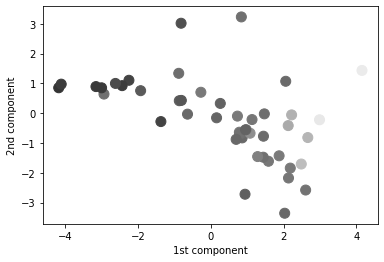

[[ 0.21562605 -0.22760909  0.01299948  0.0986543   0.17503489 -0.05171689
   0.17750063 -0.11139314  0.08255284  0.10043854  0.02657253 -0.08300075
   0.07549211]
 [-0.22760909  0.29830857  0.05916121 -0.22607272 -0.17815626 -0.02811215
  -0.22792353  0.11211606 -0.02601932 -0.05816702  0.02296961  0.01696545
   0.03131805]
 [ 0.01299948  0.05916121  0.0922893  -0.14714435  0.01884611 -0.10695258
  -0.04022082 -0.01358015  0.08171532  0.06613541  0.06565675 -0.09370317
   0.14391991]
 [ 0.0986543  -0.22607272 -0.14714435  0.30126477  0.06620709  0.15005721
   0.16640489 -0.03948047 -0.09061601 -0.05456316 -0.0950082   0.11042199
  -0.19862902]
 [ 0.17503489 -0.17815626  0.01884611  0.06620709  0.14283664 -0.05139252
   0.13947111 -0.09104579  0.07396775  0.08697666  0.02737601 -0.07541544
   0.07391279]
 [-0.05171689 -0.02811215 -0.10695258  0.15005721 -0.05139252  0.13022907
   0.01521016  0.0345066  -0.1068778  -0.09226496 -0.07905857  0.12055764
  -0.17625316]
 [ 0.17750063 -0.22792

Iter 19228: loss: 67.9657 square loss part: 66.4272

iter 137	train cost	67.96574401855469	log-likelihood	66.42723083496094
[13.35742785  5.95997438  0.93131677  0.70763015  0.62237952  0.56664577
  0.48578243  0.4217881   0.40567912  0.38640664  0.35766902  0.28608346
  0.26371665]
iter 138	total variance to retain	0.014208577025271785
Epoch 19
Iter 20240: loss: 68.3839 square loss part: 66.9334

iter 139	train cost	68.38389587402344	log-likelihood	66.93338012695312
[14.19881657  6.19880309  0.89562634  0.74463259  0.64649679  0.57995817
  0.50675202  0.43860832  0.42110809  0.3828781   0.37002846  0.32320668
  0.25922155]
iter 140	total variance to retain	0.013126227561355064
Epoch 20
Iter 21252: loss: 67.8203 square loss part: 66.3215

iter 141	train cost	67.82030487060547	log-likelihood	66.32151794433594
[14.75622566  6.51016167  1.00017335  0.83906994  0.67692963  0.58541679
  0.49585404  0.46794398  0.39751332  0.38070794  0.36285465  0.30195415
  0.26153858]
iter 142	total varia

Iter 43516: loss: 59.8087 square loss part: 58.7256

iter 185	train cost	59.808719635009766	log-likelihood	58.72560119628906
[23.76621034 13.29888319  0.76915433  0.5909607   0.53274748  0.52487728
  0.42389201  0.38200322  0.3676071   0.32777192  0.30180372  0.27482833
  0.24625268]
iter 186	total variance to retain	0.0030855118570324302
Epoch 43
Iter 44528: loss: 56.7986 square loss part: 55.8492

iter 187	train cost	56.79862594604492	log-likelihood	55.849178314208984
[23.66657083 13.34875635  0.7911441   0.60247314  0.54069836  0.50240068
  0.40025504  0.38013453  0.33945073  0.33474543  0.29978589  0.25750535
  0.24723048]
iter 188	total variance to retain	0.0030826364013791796
Epoch 44
Iter 45540: loss: 55.6295 square loss part: 54.5992

iter 189	train cost	55.62948989868164	log-likelihood	54.599178314208984
[24.49279962 13.49532733  0.83606607  0.59819156  0.51691807  0.50314097
  0.3982098   0.36861531  0.34608794  0.33421566  0.2900078   0.24520917
  0.21925401]
iter 190	total 

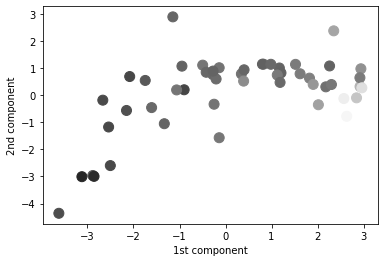

[[ 0.13544636 -0.04388562  0.07758875 -0.13211999  0.1333775   0.00564721
   0.10020107 -0.0055982   0.15133575  0.10944902 -0.02692857 -0.16457257
   0.03339268]
 [-0.04388562  0.03602559 -0.06202659  0.00354201 -0.04761502  0.08233757
  -0.03898245  0.02939554 -0.04825599 -0.06080445 -0.05513028  0.03534841
  -0.08483442]
 [ 0.07758875 -0.06202659  0.10684371 -0.00926174  0.08384615 -0.13914128
   0.06842226 -0.04986363  0.08537489  0.10556494  0.09259107 -0.06386824
   0.14433119]
 [-0.13211999  0.00354201 -0.00926174  0.1995799  -0.12217951 -0.15706553
  -0.08600614 -0.0442046  -0.14901992 -0.0611284   0.14124921  0.1928966
   0.10070339]
 [ 0.1333775  -0.04761502  0.08384615 -0.12217951  0.13222794 -0.01142097
   0.09998536 -0.01107768  0.14886723  0.11289038 -0.01363355 -0.15843225
   0.04781617]
 [ 0.00564721  0.08233757 -0.13914128 -0.15706553 -0.01142097  0.32510161
  -0.0209747   0.10622543  0.00931224 -0.09325154 -0.24758942 -0.07623825
  -0.28428812]
 [ 0.10020107 -0.038982

Iter 19228: loss: 69.3109 square loss part: 67.7734

iter 237	train cost	69.31085968017578	log-likelihood	67.7734146118164
[11.46724044  4.34758911  0.92291547  0.72346961  0.6296106   0.52676857
  0.49043126  0.44288168  0.39545071  0.35392211  0.33607237  0.28849153
  0.26142749]
iter 238	total variance to retain	0.019760678282793043
Epoch 19
Iter 20240: loss: 69.0275 square loss part: 67.7464

iter 239	train cost	69.0274887084961	log-likelihood	67.7464370727539
[12.19738461  4.3087875   1.14920371  0.82241361  0.65403487  0.54176223
  0.49032572  0.40970968  0.39836142  0.38883805  0.32163296  0.26634999
  0.26318573]
iter 240	total variance to retain	0.021518441644167496
Epoch 20
Iter 21252: loss: 68.3972 square loss part: 66.7449

iter 241	train cost	68.39716339111328	log-likelihood	66.74494934082031
[12.60809738  4.3740045   0.94805077  0.7505795   0.68793929  0.57145232
  0.51745099  0.45061264  0.38742079  0.36386695  0.30762408  0.29318854
  0.26222834]
iter 242	total variance

Iter 43516: loss: 59.2509 square loss part: 58.1639

iter 285	train cost	59.25088882446289	log-likelihood	58.1639404296875
[21.67109924  6.61220218  1.21490532  0.64798465  0.61754814  0.54762211
  0.47687003  0.43250391  0.36722323  0.34147365  0.30419049  0.2690087
  0.24804269]
iter 286	total variance to retain	0.006713034816338448
Epoch 43
Iter 44528: loss: 57.5536 square loss part: 56.5945

iter 287	train cost	57.55360794067383	log-likelihood	56.594482421875
[22.09346953  6.76217503  1.41658556  0.64635721  0.6024453   0.53660431
  0.46124233  0.41394197  0.35733116  0.33115664  0.30262797  0.27339546
  0.24246213]
iter 288	total variance to retain	0.007292957365866437
Epoch 44
Iter 45540: loss: 56.1487 square loss part: 55.0713

iter 289	train cost	56.148746490478516	log-likelihood	55.0713005065918
[22.46805632  6.90638353  1.8425542   0.63765767  0.58733363  0.5206695
  0.44891081  0.40993194  0.34905642  0.32289246  0.29729127  0.28761915
  0.23763315]
iter 290	total variance t

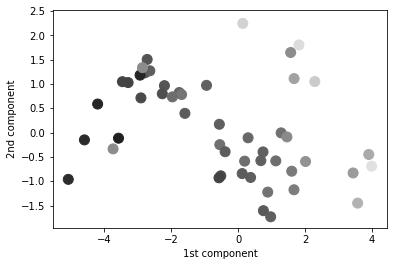

[[ 0.07064245 -0.07405993  0.09815347 -0.00624796  0.08492793 -0.06298616
   0.09637883 -0.06296167  0.04885916  0.13446276  0.0099373  -0.04677585
   0.05750511]
 [-0.07405993  0.09402107 -0.11011056 -0.03521944 -0.10581028 -0.01431047
  -0.13850345  0.08530591 -0.04558413 -0.15690845  0.01979758  0.03659885
   0.00640223]
 [ 0.09815347 -0.11011056  0.1395512   0.0097032   0.12538504 -0.05215328
   0.15040107 -0.09597539  0.06540509  0.19384409  0.00050828 -0.059517
   0.05054752]
 [-0.00624796 -0.03521944  0.0097032   0.10707779  0.03526676  0.21047149
   0.08701537 -0.04364792 -0.01870173  0.02876119 -0.0779378   0.03586255
  -0.17516377]
 [ 0.08492793 -0.10581028  0.12538504  0.03526676  0.11928103  0.00656028
   0.15423538 -0.09545821  0.05296472  0.17797977 -0.01899834 -0.04349472
   0.00083441]
 [-0.06298616 -0.01431047 -0.05215328  0.21047149  0.00656028  0.45028518
   0.09783671 -0.03852996 -0.07122439 -0.04169235 -0.15708271  0.10273003
  -0.37841638]
 [ 0.09637883 -0.1385034

[9.33098535 7.04417855 0.94961013 0.63587421 0.53962986 0.49771651
 0.48056273 0.42884391 0.36217451 0.32996495 0.27096992 0.26445658
 0.20906427]
iter 338	total variance to retain	0.01927883484841597
Epoch 19
Iter 20240: loss: 68.7528 square loss part: 67.3907

iter 339	train cost	68.75275421142578	log-likelihood	67.39065551757812
[9.9725849  7.16306442 0.90692465 0.61781196 0.54165696 0.53091019
 0.49474037 0.44118004 0.36091036 0.30393746 0.28389813 0.25436585
 0.22154204]
iter 340	total variance to retain	0.017183326798005494
Epoch 20
Iter 21252: loss: 68.0114 square loss part: 66.5373

iter 341	train cost	68.0113525390625	log-likelihood	66.53727722167969
[9.99373874 7.36134425 0.97303544 0.70577379 0.5744906  0.55045157
 0.49986599 0.41605622 0.37382486 0.3314544  0.31619424 0.27848033
 0.2330937 ]
iter 342	total variance to retain	0.01899047626253536
Epoch 21
Iter 22264: loss: 65.3018 square loss part: 63.8190

iter 343	train cost	65.30179595947266	log-likelihood	63.8190269470214

[17.91974517  2.79547282  1.03044888  0.7138108   0.58138405  0.5731514
  0.48053773  0.46126611  0.41702554  0.39379977  0.37715451  0.30703825
  0.28115967]
iter 386	total variance to retain	0.010010596014769058
Epoch 43
Iter 44528: loss: 59.5453 square loss part: 58.3381

iter 387	train cost	59.545291900634766	log-likelihood	58.33808517456055
[18.11858956  2.90958569  1.04426342  0.75076855  0.57092058  0.53736901
  0.48201008  0.46653436  0.42106178  0.39685632  0.37266449  0.30927207
  0.28012477]
iter 388	total variance to retain	0.00989848484722744
Epoch 44
Iter 45540: loss: 57.4282 square loss part: 56.1679

iter 389	train cost	57.42817306518555	log-likelihood	56.16788101196289
[19.19528958  2.7082689   1.07975362  0.73792326  0.57123979  0.52965203
  0.48111193  0.45933943  0.43305977  0.38978744  0.36398735  0.31091303
  0.27933969]
iter 390	total variance to retain	0.008983026164894548
Epoch 45
Iter 46552: loss: 56.1714 square loss part: 54.8103

iter 391	train cost	56.17138

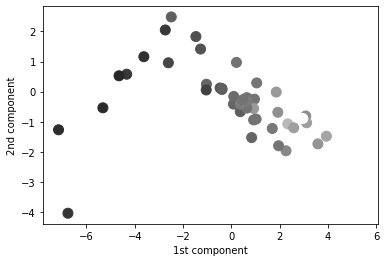

[[ 0.34575969 -0.26337687 -0.18501357 -0.03666681 -0.06807008 -0.09239257
  -0.0156379   0.07502674 -0.03000388  0.23535685  0.10548029  0.09286387
   0.16180769]
 [-0.26337687  0.22229058  0.07619871  0.03711503 -0.00724743  0.13339418
  -0.02175508 -0.02881123 -0.02033649 -0.18988652 -0.11284076 -0.0192565
  -0.16613886]
 [-0.18501357  0.07619871  0.29238965 -0.00781938  0.21298323 -0.1388227
   0.108949   -0.12481052  0.1450908  -0.09424833  0.04063172 -0.20349219
   0.04153663]
 [-0.03666681  0.03711503 -0.00781938  0.00778172 -0.01783283  0.03650978
  -0.01261281  0.00405638 -0.01512669 -0.02945523 -0.02495934  0.01197446
  -0.03533761]
 [-0.06807008 -0.00724743  0.21298323 -0.01783283  0.17459444 -0.15368747
   0.09490632 -0.09206649  0.12371281 -0.01740344  0.06785914 -0.15869823
   0.08511333]
 [-0.09239257  0.13339418 -0.1388227   0.03650978 -0.15368747  0.20795724
  -0.09373507  0.06237052 -0.11759626 -0.09374018 -0.12268504  0.12490771
  -0.16795858]
 [-0.0156379  -0.0217550

[7.70596497 3.80529111 0.99177442 0.74758033 0.52469111 0.44570968
 0.38395191 0.37449406 0.33721006 0.31213984 0.30167356 0.27369814
 0.24187726]
iter 438	total variance to retain	0.03576520563157903
Epoch 19
Iter 20240: loss: 76.3508 square loss part: 74.6771

iter 439	train cost	76.35077667236328	log-likelihood	74.6771011352539
[8.3035678  3.98227244 0.94604046 0.70548252 0.63386883 0.4625311
 0.42314422 0.36691706 0.34636341 0.31646847 0.29528608 0.28583378
 0.24796453]
iter 440	total variance to retain	0.03165782752458246
Epoch 20
Iter 21252: loss: 73.2985 square loss part: 71.8393

iter 441	train cost	73.29853057861328	log-likelihood	71.83931732177734
[8.43595317 3.96797172 0.8969423  0.7654226  0.52832383 0.47883815
 0.42266463 0.38738251 0.34715152 0.32578538 0.31717728 0.29304513
 0.2450079 ]
iter 442	total variance to retain	0.03013762949713983
Epoch 21
Iter 22264: loss: 73.3141 square loss part: 71.7125

iter 443	train cost	73.31410217285156	log-likelihood	71.7125244140625
[

[20.81655236  3.76159865  0.82231647  0.74637228  0.62982062  0.56110127
  0.45044754  0.41971415  0.40734895  0.36679585  0.33727618  0.29903861
  0.24938313]
iter 486	total variance to retain	0.006416286437984198
Epoch 43
Iter 44528: loss: 63.1804 square loss part: 61.8977

iter 487	train cost	63.180416107177734	log-likelihood	61.897674560546875
[20.8910778   3.56538865  0.80974594  0.72250053  0.61585829  0.52370587
  0.44630073  0.41278757  0.40887015  0.35641113  0.33716225  0.30282422
  0.24757654]
iter 488	total variance to retain	0.006111164498684096
Epoch 44
Iter 45540: loss: 64.6887 square loss part: 63.4123

iter 489	train cost	64.6886978149414	log-likelihood	63.412296295166016
[21.44541542  3.172137    0.80893476  0.75072479  0.63790198  0.51980844
  0.46589358  0.4102305   0.40294326  0.35256841  0.33281967  0.30486433
  0.23851539]
iter 490	total variance to retain	0.005980798014338373
Epoch 45
Iter 46552: loss: 63.6357 square loss part: 62.3416

iter 491	train cost	63.63

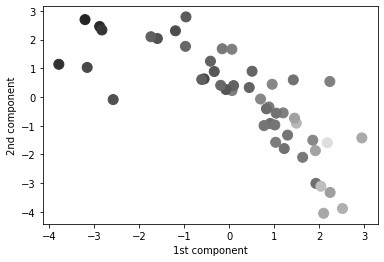

[[ 1.18844535e-01 -1.09362407e-02  8.55471355e-02 -8.37781727e-02
   1.39149170e-01 -1.35473551e-01  2.95597150e-02 -1.46543949e-02
   5.74293679e-02  6.88673982e-02  6.72592044e-02 -1.45022460e-01
   1.33654584e-01]
 [-1.09362407e-02  3.87757791e-01 -6.59945934e-02 -1.19744552e-01
   9.17164553e-02  2.42170372e-03 -1.82503680e-01  2.27315252e-01
  -1.40420538e-01 -2.27797583e-01 -1.18143399e-01 -1.87401090e-01
  -6.71100145e-02]
 [ 8.55471355e-02 -6.59945934e-02  7.03137238e-02 -4.11512839e-02
   8.44550729e-02 -9.60075344e-02  4.82963226e-02 -4.45076953e-02
   6.16477370e-02  8.28542680e-02  6.52396580e-02 -7.42217454e-02
   1.04444951e-01]
 [-8.37781727e-02 -1.19744552e-01 -4.11512839e-02  1.01060965e-01
  -1.32536655e-01  9.88108694e-02  3.84098701e-02 -6.41368825e-02
   4.04979378e-03  2.44349182e-02 -1.05191711e-02  1.68387951e-01
  -7.61554131e-02]
 [ 1.39149170e-01  9.17164553e-02  8.44550729e-02 -1.32536655e-01
   1.91170130e-01 -1.61333897e-01 -1.39772382e-02  4.39103318e-02


Iter 17204: loss: 80.7467 square loss part: 79.1229

iter 533	train cost	80.7467269897461	log-likelihood	79.1229019165039
[11.26014367  2.05230987  1.16675469  0.66442084  0.61212935  0.49664878
  0.43440856  0.39565947  0.31739839  0.29773361  0.25992463  0.25509485
  0.21510346]
iter 534	total variance to retain	0.02339101185770709
Epoch 17
Iter 18216: loss: 79.2545 square loss part: 77.6665

iter 535	train cost	79.25446319580078	log-likelihood	77.66651153564453
[11.69232437  2.09027313  1.36394125  0.96033869  0.61900961  0.51098113
  0.42351132  0.37086536  0.33932871  0.31700702  0.28224157  0.2624946
  0.22592151]
iter 536	total variance to retain	0.02863565633412657
Epoch 18
Iter 19228: loss: 79.8812 square loss part: 78.2047

iter 537	train cost	79.8812484741211	log-likelihood	78.2046890258789
[12.142193    2.10012843  1.15877433  0.74845248  0.62494696  0.49142887
  0.44081322  0.41128244  0.37460231  0.32278206  0.28196839  0.27094013
  0.22052034]
iter 538	total variance to 

Iter 41492: loss: 65.3052 square loss part: 64.0170

iter 581	train cost	65.3051528930664	log-likelihood	64.0169906616211
[18.95292511  6.1296025   0.94851961  0.79814781  0.58030473  0.47184977
  0.46219765  0.43310349  0.3965174   0.3807469   0.35717776  0.32899987
  0.28152294]
iter 582	total variance to retain	0.0077884391317764035
Epoch 41
Iter 42504: loss: 64.5699 square loss part: 63.1690

iter 583	train cost	64.56985473632812	log-likelihood	63.16897201538086
[19.08091874  6.6564536   0.94242259  0.78720729  0.55884628  0.46886426
  0.45254819  0.43042257  0.40460936  0.38824095  0.36419681  0.3202873
  0.27985876]
iter 584	total variance to retain	0.007432401665658839
Epoch 42
Iter 43516: loss: 65.1370 square loss part: 64.0290

iter 585	train cost	65.13704681396484	log-likelihood	64.02901458740234
[19.51989346  6.85093655  0.93321802  0.76960375  0.52992659  0.4726199
  0.45432184  0.42246319  0.39435208  0.38400315  0.35402234  0.30122128
  0.28091462]
iter 586	total variance

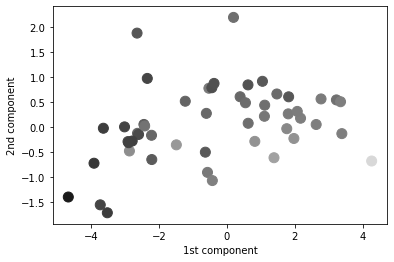

[[ 0.3895744  -0.07871905  0.05260001 -0.2919355   0.13355743  0.10570034
   0.0079452  -0.12331916  0.12368906 -0.00863701 -0.0836678  -0.27697598
  -0.0156821 ]
 [-0.07871905  0.05659079 -0.06836981  0.03504184 -0.07901302  0.06242592
  -0.04392151  0.03597111 -0.06282348 -0.07051161 -0.06561597  0.07528054
  -0.09505186]
 [ 0.05260001 -0.06836981  0.08905093 -0.00542899  0.09187019 -0.10463866
   0.0611296  -0.03233696  0.0703909   0.10138396  0.10582248 -0.06480779
   0.13728173]
 [-0.2919355   0.03504184 -0.00542899  0.23286412 -0.0694603  -0.12852611
   0.01895437  0.08590583 -0.07042105  0.04900446  0.11127277  0.19618913
   0.06956677]
 [ 0.13355743 -0.07901302  0.09187019 -0.0694603   0.11231612 -0.07090301
   0.05683609 -0.05641121  0.09078027  0.08943841  0.07684268 -0.11965295
   0.12022471]
 [ 0.10570034  0.06242592 -0.10463866 -0.12852611 -0.07090301  0.20122105
  -0.08498849 -0.01069771 -0.04434682 -0.15114659 -0.19264434 -0.0353761
  -0.20652702]
 [ 0.0079452  -0.043921

Iter 19228: loss: 70.2201 square loss part: 68.7347

iter 637	train cost	70.22010803222656	log-likelihood	68.73467254638672
[12.15020173  3.91753212  0.88032402  0.63534801  0.61021453  0.56272086
  0.49682354  0.46393742  0.37172855  0.34079704  0.31493884  0.26612963
  0.22174463]
iter 638	total variance to retain	0.016909587906623003
Epoch 19
Iter 20240: loss: 69.0937 square loss part: 67.6673

iter 639	train cost	69.09368133544922	log-likelihood	67.66728973388672
[12.86263508  3.93164573  0.91001438  0.73871534  0.63217589  0.58875468
  0.50126466  0.48365499  0.3939374   0.35062404  0.32209223  0.26962464
  0.23024992]
iter 640	total variance to retain	0.01691612533380049
Epoch 20
Iter 21252: loss: 68.9332 square loss part: 67.3955

iter 641	train cost	68.93317413330078	log-likelihood	67.3954849243164
[13.01031868  3.95286648  0.94490745  0.73854721  0.63509815  0.55986576
  0.49628498  0.48525339  0.41056661  0.37181292  0.34451971  0.29488611
  0.23960689]
iter 642	total varianc

Iter 43516: loss: 59.0988 square loss part: 57.9314

iter 685	train cost	59.09880447387695	log-likelihood	57.931392669677734
[21.00346563  4.42328127  1.23868073  0.7100401   0.5311915   0.48681662
  0.44856675  0.42111571  0.37943226  0.34792409  0.31275387  0.28681789
  0.23611398]
iter 686	total variance to retain	0.007405054885518125
Epoch 43
Iter 44528: loss: 59.3071 square loss part: 58.0324

iter 687	train cost	59.30708694458008	log-likelihood	58.032405853271484
[21.81970873  4.64212718  1.12287774  0.71022043  0.52162695  0.47959846
  0.46135682  0.41642169  0.37619082  0.37055674  0.29267537  0.28309272
  0.24044004]
iter 688	total variance to retain	0.0063020074896879
Epoch 44
Iter 45540: loss: 57.4454 square loss part: 56.2992

iter 689	train cost	57.44535827636719	log-likelihood	56.29924011230469
[22.2254732   4.75837434  1.41203534  0.70392334  0.51177642  0.47763308
  0.44124766  0.415081    0.37370625  0.34465636  0.3089149   0.28686624
  0.22375689]
iter 690	total varia

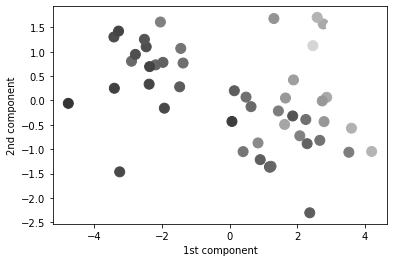

[[ 0.06605023 -0.05613667  0.06519091 -0.02288167  0.06718833 -0.11252213
   0.04881748 -0.04472878  0.05812593  0.06670908  0.08777016 -0.05428593
   0.11715053]
 [-0.05613667  0.06310563 -0.11726853 -0.03337148 -0.07079208  0.06099591
  -0.05242612  0.06102508 -0.06908507 -0.1114737  -0.05150027  0.05920502
  -0.05044988]
 [ 0.06519091 -0.11726853  0.31293234  0.18966525  0.12131914  0.02813103
   0.0921269  -0.13660997  0.13646602  0.28595957 -0.00618302 -0.10608836
  -0.0817488 ]
 [-0.02288167 -0.03337148  0.18966525  0.1891482   0.02368803  0.15782256
   0.0206087  -0.06345098  0.04739706  0.16483021 -0.10964964 -0.02602647
  -0.20910595]
 [ 0.06718833 -0.07079208  0.12131914  0.02368803  0.08051688 -0.08366285
   0.05938217 -0.06595863  0.07662897  0.1165637   0.06874634 -0.06683982
   0.0754963 ]
 [-0.11252213  0.06099591  0.02813103  0.15782256 -0.08366285  0.26962518
  -0.05855944  0.02442768 -0.05473514  0.00960323 -0.20149037  0.06308021
  -0.31008929]
 [ 0.04881748 -0.05242

Iter 19228: loss: 67.2869 square loss part: 65.6629

iter 737	train cost	67.28687286376953	log-likelihood	65.66293334960938
[12.71774166 11.76899926  1.17186477  0.74278929  0.66483289  0.64774297
  0.53532685  0.49068887  0.44962367  0.35884038  0.3223382   0.28992801
  0.2602852 ]
iter 738	total variance to retain	0.012824436928970173
Epoch 19
Iter 20240: loss: 66.3199 square loss part: 64.8446

iter 739	train cost	66.31988525390625	log-likelihood	64.84459686279297
[12.76387616 12.34207979  1.13236617  0.70638991  0.67454097  0.66368582
  0.54015054  0.5055023   0.41687074  0.36880663  0.34033995  0.31679033
  0.26950201]
iter 740	total variance to retain	0.01198070754503755
Epoch 20
Iter 21252: loss: 66.2533 square loss part: 64.6897

iter 741	train cost	66.2532730102539	log-likelihood	64.68968963623047
[13.10320571 12.48618692  1.16079485  0.76699135  0.67965547  0.6626953
  0.54524774  0.51595262  0.41948011  0.37562232  0.32928485  0.30559574
  0.27198371]
iter 742	total variance

Iter 43516: loss: 54.7570 square loss part: 53.6257

iter 785	train cost	54.75704574584961	log-likelihood	53.62570571899414
[24.76284476 11.13767929  0.62995731  0.59533691  0.56258304  0.53344589
  0.51838684  0.43147845  0.38960648  0.35261612  0.32884333  0.30518264
  0.27260312]
iter 786	total variance to retain	0.003189475637918382
Epoch 43
Iter 44528: loss: 55.2405 square loss part: 54.1684

iter 787	train cost	55.240478515625	log-likelihood	54.16835403442383
[25.65345637 11.23932897  0.67860989  0.59764527  0.5447787   0.52836141
  0.49837822  0.41939411  0.39707862  0.36395797  0.32893581  0.30539101
  0.2681387 ]
iter 788	total variance to retain	0.00302668964079178
Epoch 44
Iter 45540: loss: 54.9097 square loss part: 53.7777

iter 789	train cost	54.90974807739258	log-likelihood	53.7776985168457
[25.94328698 11.32355239  0.64594208  0.60346843  0.53469256  0.52365351
  0.50732734  0.40074812  0.36376325  0.34878093  0.32307757  0.29156169
  0.26517503]
iter 790	total variance 

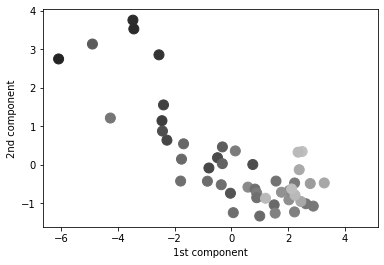

[[ 0.06711975 -0.06127153  0.08631598 -0.01428441  0.06559588 -0.14508416
   0.03127659 -0.0129451   0.07411044  0.04791101  0.08801463 -0.01398644
   0.09475203]
 [-0.06127153  0.0559691  -0.07900576  0.01467959 -0.05988146  0.13020621
  -0.02943246  0.012934   -0.06681482 -0.04676172 -0.0797634   0.01645318
  -0.08813719]
 [ 0.08631598 -0.07900576  0.11222653 -0.02790181  0.08436223 -0.17357694
   0.04534312 -0.02313942  0.0904331   0.07919922  0.10980129 -0.03940963
   0.13139022]
 [-0.01428441  0.01467959 -0.02790181  0.07725897 -0.01400648 -0.07035411
  -0.04653304  0.05330353  0.0221694  -0.14712291  0.00762895  0.16978191
  -0.09443926]
 [ 0.06559588 -0.05988146  0.08436223 -0.01400648  0.06410663 -0.14172694
   0.03059142 -0.01268278  0.07240414  0.04690881  0.08599989 -0.01377314
   0.09264722]
 [-0.14508416  0.13020621 -0.17357694 -0.07035411 -0.14172694  0.45168363
  -0.01321673 -0.0409639  -0.2119454   0.0831977  -0.22620392 -0.19728127
  -0.10350716]
 [ 0.03127659 -0.02943

Iter 19228: loss: 74.9875 square loss part: 73.4260

iter 837	train cost	74.98747253417969	log-likelihood	73.4260025024414
[13.62183572  8.34860715  0.97294104  0.62474693  0.54756435  0.50469753
  0.45998497  0.39085608  0.35436571  0.32310784  0.27730104  0.22557716
  0.20462403]
iter 838	total variance to retain	0.010296067802137765
Epoch 19
Iter 20240: loss: 73.5701 square loss part: 72.0737

iter 839	train cost	73.57012176513672	log-likelihood	72.07367706298828
[14.08207412  8.93527224  0.98492664  0.65036783  0.55302348  0.51209494
  0.46442106  0.3997577   0.37523111  0.34292507  0.29449999  0.22938585
  0.21109517]
iter 840	total variance to retain	0.009892159194913819
Epoch 20
Iter 21252: loss: 73.2757 square loss part: 71.6838

iter 841	train cost	73.27571105957031	log-likelihood	71.68376922607422
[14.00446004  9.25248469  1.00775111  0.63881121  0.56458101  0.51753638
  0.46471654  0.41409684  0.37012795  0.35745637  0.29647431  0.23985378
  0.21466331]
iter 842	total varian

Iter 43516: loss: 63.2295 square loss part: 62.0845

iter 885	train cost	63.22945022583008	log-likelihood	62.084537506103516
[19.25595905 10.80334721  0.78639373  0.61278463  0.56928912  0.55565823
  0.47820435  0.47002933  0.41463739  0.36095986  0.31783091  0.30569254
  0.26481733]
iter 886	total variance to retain	0.005392626311179649
Epoch 43
Iter 44528: loss: 62.6004 square loss part: 61.4928

iter 887	train cost	62.60035705566406	log-likelihood	61.49282455444336
[19.60825706 10.77313236  0.71195334  0.60958889  0.5700237   0.55915075
  0.47150437  0.45737287  0.4004481   0.35476272  0.32284766  0.30450423
  0.26533321]
iter 888	total variance to retain	0.004971977099593516
Epoch 44
Iter 45540: loss: 61.8762 square loss part: 60.8395

iter 889	train cost	61.876224517822266	log-likelihood	60.83952331542969
[19.96570276 10.51463988  0.76612249  0.58223245  0.56796552  0.54861967
  0.47490994  0.44874429  0.40381183  0.35153266  0.30842376  0.2996198
  0.25594702]
iter 890	total vari

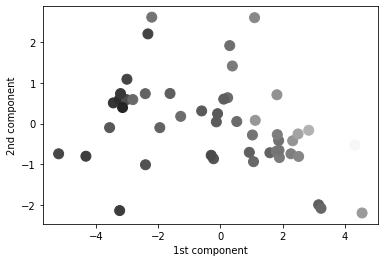

[[ 0.13610047 -0.00115626  0.07580621 -0.14816848  0.033252   -0.15696027
  -0.00649432  0.04279852  0.08364014  0.03785195  0.01329506 -0.1923434
   0.12906593]
 [-0.00115626  0.08377022 -0.05306657 -0.0646634  -0.1131567  -0.01088926
  -0.09602044  0.12577304 -0.03647606 -0.10512715 -0.09353649 -0.04963085
  -0.09054119]
 [ 0.07580621 -0.05306657  0.07503242 -0.04126967  0.08916473 -0.07977509
   0.05651293 -0.05510604  0.06897077  0.08667699  0.06587553 -0.07504797
   0.12786819]
 [-0.14816848 -0.0646634  -0.04126967  0.21318951  0.05263526  0.18049762
   0.08268485 -0.14586715 -0.06290789  0.04127716  0.05905347  0.24974566
  -0.07011428]
 [ 0.033252   -0.1131567   0.08916473  0.05263526  0.16023161 -0.02187728
   0.1278833  -0.15952324  0.06863192  0.15048231  0.12914434  0.02209057
   0.15206758]
 [-0.15696027 -0.01088926 -0.07977509  0.18049762 -0.02187728  0.18280081
   0.02150953 -0.06776464 -0.09124039 -0.02835967 -0.00169993  0.22930427
  -0.13579535]
 [-0.00649432 -0.096020

Iter 19228: loss: 72.8119 square loss part: 71.2176

iter 937	train cost	72.81194305419922	log-likelihood	71.21760559082031
[13.35798814  4.41202522  0.83967594  0.70219814  0.59020788  0.55728271
  0.4401438   0.40988421  0.39573039  0.36818711  0.30912407  0.29444126
  0.25132544]
iter 938	total variance to retain	0.013736599602675037
Epoch 19
Iter 20240: loss: 71.6205 square loss part: 70.1046

iter 939	train cost	71.6204833984375	log-likelihood	70.1045913696289
[14.01115994  4.7258242   0.83121611  0.75146057  0.62410106  0.54036495
  0.4826934   0.43748415  0.38762571  0.376307    0.31767545  0.30873076
  0.25293448]
iter 940	total variance to retain	0.01315024959487121
Epoch 20
Iter 21252: loss: 70.0541 square loss part: 68.6530

iter 941	train cost	70.05406951904297	log-likelihood	68.65300750732422
[14.62273593  5.10408921  0.81516305  0.65737455  0.597962    0.51195618
  0.46109427  0.42855701  0.3891179   0.36146489  0.33312949  0.30063813
  0.25691808]
iter 942	total variance

Iter 43516: loss: 59.1013 square loss part: 57.9538

iter 985	train cost	59.10133361816406	log-likelihood	57.953792572021484
[20.96742432 13.14394562  0.80143487  0.62730117  0.55208224  0.48351834
  0.45350829  0.43017121  0.38909367  0.33019617  0.29476721  0.28773744
  0.24971467]
iter 986	total variance to retain	0.003996995642105872
Epoch 43
Iter 44528: loss: 58.4178 square loss part: 57.3347

iter 987	train cost	58.41777420043945	log-likelihood	57.334712982177734
[21.12469882 13.31189989  0.79673112  0.70716331  0.51638408  0.4809794
  0.46504124  0.42734929  0.41830567  0.3823687   0.32023024  0.288081
  0.24674221]
iter 988	total variance to retain	0.00415192567092193
Epoch 44
Iter 45540: loss: 59.2868 square loss part: 58.1149

iter 989	train cost	59.28676986694336	log-likelihood	58.11485290527344
[21.85119052 13.5300743   0.75995851  0.66882808  0.52671251  0.48718323
  0.45955725  0.4439055   0.38869036  0.34266107  0.31243712  0.28870073
  0.24100254]
iter 990	total varianc

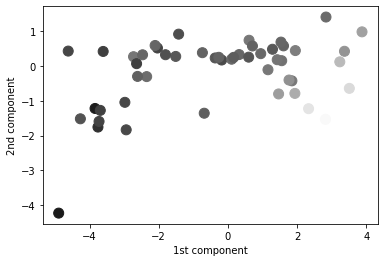

[[ 4.28329736e-01 -1.89746427e-01 -5.62940023e-02 -8.17997729e-02
   1.39475909e-01  2.16428094e-01 -1.04551511e-02 -1.19483768e-01
  -4.04850135e-02 -6.64669178e-04  3.30838941e-02 -2.95315041e-01
   1.68446204e-01]
 [-1.89746427e-01  9.33610995e-02 -8.87529757e-03  3.93102171e-02
  -8.32451009e-02 -4.13449377e-02 -1.80993023e-02  6.34102833e-02
  -1.02488395e-02 -3.55198890e-02 -4.10589150e-02  1.38260112e-01
  -1.08908404e-01]
 [-5.62940023e-02 -8.87529757e-03  1.30269819e-01 -4.18342323e-04
   5.96457556e-02 -2.26600928e-01  8.39743576e-02 -2.23792510e-02
   1.07734641e-01  1.30230932e-01  9.15963006e-02  1.17835732e-02
   1.02459401e-01]
 [-8.17997729e-02  3.93102171e-02 -4.18342323e-04  1.66368830e-02
  -3.37243405e-02 -2.33196397e-02 -5.51172088e-03  2.62799912e-02
  -1.57785897e-03 -1.17031428e-02 -1.50395244e-02  5.88543637e-02
  -4.34947778e-02]
 [ 1.39475909e-01 -8.32451009e-02  5.96457556e-02 -3.37243405e-02
   9.49027436e-02 -5.52792310e-02  4.90153374e-02 -6.30752008e-02


In [6]:
scores = []
for part in range(10):
    print("Current part is %d\n" % part)
    train_x = np.concatenate((_train_x[0:(part*50)], _train_x[(part+1)*50:506]), axis=0)
    train_y = np.concatenate((_train_y[0:(part*50)], _train_y[(part+1)*50:506]), axis=0)
    test_x = _train_x[part*50:(part+1)*50]
    test_y = _train_y[part*50:(part+1)*50]
    scaler = preprocessing.StandardScaler().fit(train_x)
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    cur_w = np.random.normal(0, 0.35, (number_of_neurons,1))
    cur_B =  np.random.normal(0, 0.35, (dimensionality, number_of_neurons))
    cur_biases = np.zeros((number_of_neurons))
    cur_P = np.zeros((dimensionality, dimensionality)) 
    O = np.zeros((dimensionality, k)) 
    cur_iter = 0
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for epoch in range(num_epochs):
        print("Epoch %d" %(epoch))
        for iteration in range(num_iters):
            offset = (cur_iter % 12)*BATCH_SIZE
            sample_x = np.reshape(train_x[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, dimensionality))
            sample_y = np.reshape(train_y[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, 1))
            sess.run(target, feed_dict={tf_data_x: sample_x, tf_data_y: sample_y, 
                                  tf_data_w: cur_w, tf_data_B: cur_B, tf_data_biases: cur_biases,
                                  tf_data_P: cur_P, Lbd: Lambda, batch_size: BATCH_SIZE})
            cur_iter = cur_iter+1
        reses = []
        outes = []
        for i in range(12):
            offset = (cur_iter % 12)*BATCH_SIZE
            sample_x = np.reshape(train_x[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, dimensionality))
            sample_y = np.reshape(train_y[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, 1))
            res, out = sess.run([loss, out_loss], feed_dict={tf_data_x: sample_x, tf_data_y: sample_y, 
                                  tf_data_w: cur_w, tf_data_B: cur_B, tf_data_biases: cur_biases,
                                  tf_data_P: cur_P, Lbd: Lambda, batch_size: BATCH_SIZE})
            reses.append(res)
            outes.append(out)
            cur_iter = cur_iter+1
        print ("Iter %d: loss: %.4f square loss part: %.4f\n" %(cur_iter, np.mean(np.array(reses)), np.mean(np.array(outes))))
        lib.plot.plot('train cost', np.mean(np.array(reses)))
        lib.plot.plot('log-likelihood', np.mean(np.array(outes)))
        lib.plot.tick()
        lib.plot.flush()

        cur_w, cur_B, cur_biases = sess.run([w, B, biases], feed_dict={})    
        third_x = np.random.normal(0, 0.35, (M,dimensionality))
        third_sigma_prime = np.multiply(1.0-logistic.cdf(np.add(np.matmul(third_x, cur_B), np.tile(np.reshape(cur_biases,[1, number_of_neurons]),(M,1)))), 
                           logistic.cdf(np.add(np.matmul(third_x, cur_B), np.tile(np.reshape(cur_biases,[1, number_of_neurons]),(M,1)))))
        third_w_M_times = np.tile(np.reshape(cur_w,[1, number_of_neurons]), (M,1))
        third_grad_psi = np.matmul(np.multiply(third_w_M_times, third_sigma_prime), np.transpose(cur_B))
        
        u, s, vh = np.linalg.svd(np.transpose(third_grad_psi), full_matrices=True)
        O = u[:,0:k:1]
        print(s)
        cur_P = np.matmul(O, np.transpose(O))
        tvr = 1-np.sum(np.multiply(s[0:k],s[0:k]))/np.sum(np.multiply(s,s))
        lib.plot.plot('total variance to retain', tvr)
        lib.plot.tick()
        lib.plot.flush()
    reduced_train_x = np.matmul(train_x, O)
    reduced_test_x = np.matmul(test_x, O)
    reg = LinearRegression().fit(reduced_train_x, train_y)
    score = reg.score(reduced_test_x, test_y)
    scores.append(score)
    print ("Part %d: score on test %.4f\n" %(part, score))
    color = [str(item/50.) for item in test_y]
    plt2.close()
    plt2.scatter(np.transpose(reduced_test_x)[0], np.transpose(reduced_test_x)[1], s=100, c=color)
    plt2.xlabel("1st component")
    plt2.ylabel("2nd component")
    plt2.show()
    sess.close()
    print(cur_P)
print ("Average score on test %.4f\n" %(np.mean(np.array(scores))))